In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torch.optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

### Check if PyTorch recognizes GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Create function to extract frames from a video file

In [3]:
# https://docs.opencv.org/4.x/d8/dfe/classcv_1_1VideoCapture.html

def frame_extract(filepath, max_frames, frame_size):
    frames = []

    # begin reading from video
    capture = cv2.VideoCapture(filepath)
    if not capture.isOpened():
        print("Cannot open file")
        exit()
    while True:
        retval, image = capture.read()
        if not retval:
            break
        image = cv2.resize(image, frame_size)
        frames.append(image)

    # stop reading from video
    capture.release()

    # pad video by repeating animation until all samples are of equal length Holding -> 209
    # Pad video by repeating frames cyclically if it's shorter than max_frames
    while len(frames) < max_frames:
        num_padded = max_frames - len(frames)
        repeat_frames = frames[:num_padded]  # Repeat from the start
        frames.extend(repeat_frames)

    return np.array(frames)


#### Verify that the correct amount of frames are extracted

In [4]:
filename = 'Pointing_Day_Plain_front_30fps.mkv'
test_filepath = './dataset/Pointing/Day/Plain/' + filename
max_frames = 210 # longest animation is Holding_Something_In_Pain at 209 frames
frame_size = (299, 299)
test_frames = frame_extract(test_filepath, max_frames, frame_size)
print(test_frames.shape)# prints (num frames, height, width, channels)

(210, 299, 299, 3)


#### Display example frames from image sequence

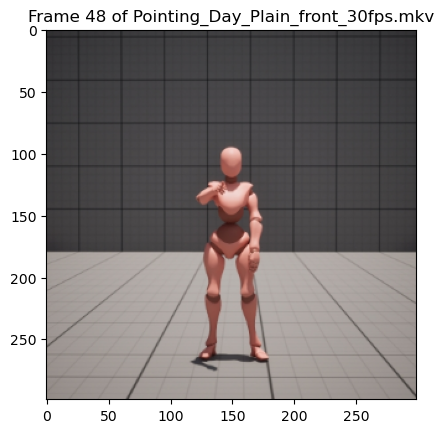

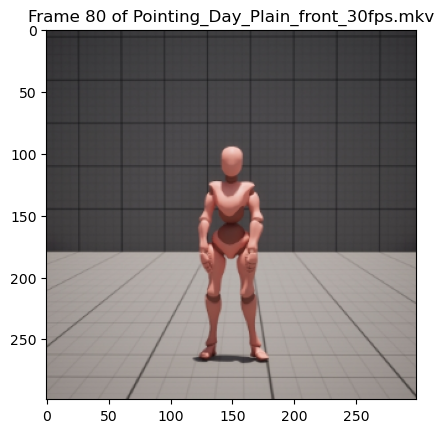

In [5]:
ex_frame1 = 48
example_frame = cv2.cvtColor(test_frames[ex_frame1], cv2.COLOR_BGR2RGB)

plt.imshow(example_frame)
plt.title(f'Frame {ex_frame1} of {filename}')
plt.show()

ex_frame2 = 80
example_frame2 = cv2.cvtColor(test_frames[ex_frame2], cv2.COLOR_BGR2RGB)
plt.imshow(example_frame2)
plt.title(f'Frame {ex_frame2} of {filename}')
plt.show()

### Define dataset with PyTorch

In [6]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class DistressActionDataset(Dataset):
    def __init__(self, root, max_frames, frame_size):
        self.root = root
        self.labels = []
        self.data = []
        self.max_frames = max_frames
        self.frame_size = frame_size

        #self.transform = transform
        self.label_map = {
            "Holding_Something_In_Pain": 0,
            "Injured_Walk": 1,
            "Jumping": 2,
            "Pointing": 3,
            "Running": 4,
            "Waving": 5,
            "Blowing_a_kiss": 6,
            "Greeting": 7,
            "Rumba_Dancing": 8,
            "Salute": 9,
            "Silly_Dancing": 10,
            "Sitting": 11
        }

        # add all mp4's to 'videos', and appropriate label (as filepaths) to 'labels'
        # Distress Labels: Holding_Something_In_Pain, Injured_Walk, Jumping, Pointing, Running, Waving
        # Non-Distress Labels: Blowing_a_kiss, Greeting, Rumba_Dancing, Salute, Silly_Dancing, Sitting
        
        for label_folder in os.listdir(root):
            label_filepath = os.path.join(root, label_folder)
            # Times: Day, Night
            for time_folder in os.listdir(label_filepath):
                time_filepath = os.path.join(label_filepath, time_folder)
                # Environments: Rural, Plain, Grassy
                for env_folder in os.listdir(time_filepath):
                    env_filepath = os.path.join(time_filepath, env_folder)
                    # Direction: Right, Left, Front, Back
                    for video in os.listdir(env_filepath):
                        if video.endswith(".mkv"):
                            video_file = os.path.join(env_filepath, video)
                            print(env_filepath)
                            data_frames = frame_extract(video_file, self.max_frames, self.frame_size)
                            self.data.append(data_frames)
                            self.labels.append(self.label_map[label_folder])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video = self.data[idx]
        label = self.labels[idx]

        # put frames on tensor in (frames, channels, height, width) order
        # normalize pixel values
        frames = torch.from_numpy(video).permute(0, 3, 1, 2).float() / 255.0
        # Apply transform to all frames in video
        # if self.transform:
        #     for i in range(len(frames)):
        #         frames[i] = self.transform(frames[i])
        
        # convert to tensor
        label = torch.tensor(label, dtype=torch.long)

        return frames, label

## Define Model using PyTorch

In [7]:
# pretrained CNN models - https://pytorch.org/vision/0.9/models.html
from torchvision.models import inception_v3
from torchvision.models.inception import InceptionOutputs

class DistressClassifier(nn.Module):
    def __init__(self, classes=12):
        super().__init__()
        self.cnn = inception_v3(pretrained=True)

        # freeze cnn base model parameters
        for param in self.cnn.parameters():
            param.requires_grad = False

        self.cnn.fc = nn.Sequential(nn.Linear(self.cnn.fc.in_features, 128))

        # unfreeze fc layer parameters
        for param in self.cnn.fc.parameters():
            param.requires_grad = True
            
        # TODO: can stack multiple LSTM cells with 'num_layers' arg
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2)
        self.fc1 = nn.Linear(64, 48)
        self.fc2 = nn.Linear(48, classes)
        
    def forward(self, x):
        hidden = None

        for t in range(x.size(1)):
            with torch.no_grad():
                cnn_x = self.cnn(x[:, t])
                if isinstance(cnn_x, InceptionOutputs):
                    cnn_x = cnn_x.logits  # Extract features from InceptionOutputs
                else:
                    cnn_x = cnn_x  # If it's already a tensor, use it directly


            # pass latent representation of frame through lstm and update hidden state
            _, hidden = self.lstm(cnn_x.unsqueeze(0), hidden)         

        # get the last hidden state
        cnn_x = self.fc1(F.relu(hidden[0][-1]))
        cnn_x = F.relu(cnn_x)
        cnn_x = self.fc2(cnn_x)

        return cnn_x

#### Define Transforms

In [8]:
# from torchvision.transforms import v2

# augment = v2.Compose([
#     v2.RandomHorizontalFlip(),
#     v2.RandomVerticalFlip(),
#     v2.GaussianNoise()
# ])

### Segment Dataset into Training and Test portions.

In [ ]:
max_frames = 210 # longest animation is Holding_Something_In_Pain at 209 frames
frame_size = (299, 299)
dataset_path = './dataset'

dataset = DistressActionDataset(dataset_path, max_frames, frame_size)

# 80% of dataset set aside for training, 20% for test
train_len = int(len(dataset)*0.8)      
train_set, test_set = random_split(dataset, [train_len, len(dataset)-train_len])

### Define DataLoader, Optimizer, Loss Function, and Model

In [ ]:
model = DistressClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=True)

### Create Training Loop

In [11]:
# This training loop is modified from https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

def train_model(model, train_loader, optimizer, loss_fn, epoch_count):
    for epoch_index in range(epoch_count):
        num_batches = len(train_loader)
        print(f"Epoch {epoch_index + 1}/{epoch_count}")
        total_loss = 0.0
        batch_loss = 0.0

        for i, data in enumerate(train_loader):
            # get sample, move to device
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero gradients
            optimizer.zero_grad()

            # make predictions for batch
            outputs = model(inputs)

            # compute loss and gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # adjust learning weights
            optimizer.step()

            # gather training data and print periodically
            batch_loss += loss.item()
            total_loss += batch_loss
            
            print(f"  Batch {i + 1}/{num_batches} loss: {batch_loss:.4f}")
            batch_loss = 0.0

        print(f"Epoch {epoch_index + 1} complete. Epoch loss: {total_loss:.4f}")

### Train Model

In [ ]:
epochs = 24
train_model(model, train_dataloader, optimizer, loss_fn, epochs)

### Save model weights

In [13]:
torch.save(model.state_dict(), f'./models/model_weights12.pth')

### Load model weights (if desired)

In [14]:
#saved_model_path = './models/model_weights8-3.4.pth'
#model.load_state_dict(torch.load(saved_model_path))

#### Evaluate Model

In [15]:
def evaluate_model_allclass(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions, labels=list(range(12)), target_names=[
        "Holding_Something_In_Pain", 
        "Injured_Walk",
        "Jumping",
        "Pointing",
        "Running",
        "Waving",
        "Blowing_a_kiss",
        "Greeting",
        "Rumba_Dancing",
        "Salute",
        "Silly_Dancing",
        "Sitting"
    ], zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_predictions, labels=list(range(12)))
    return accuracy, report, conf_mat

In [16]:
# evaluation of binary classification (distress vs non distress classes)
def eval_distress_binary(model, test_loader, device):
    # define distress vs non distress label maps
    distress_labels = {0, 1, 2, 3, 4, 5}  

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # remap 12 class labels into binary classification
            binary_labels = torch.zeros_like(labels)  # Default all to 0
            binary_labels[torch.isin(labels, torch.tensor(list(distress_labels)).to(device))] = 1
            
            # forward pass through model, obtain predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # map predictions to binary classification problem
            binary_predictions = torch.zeros_like(predicted)
            binary_predictions[torch.isin(predicted, torch.tensor(list(distress_labels)).to(device))] = 1

            total += labels.size(0)
            correct += (binary_predictions == binary_labels).sum().item()
            all_predictions.extend(binary_predictions.cpu().tolist())
            all_labels.extend(binary_labels.cpu().tolist())

    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions, labels=list(range(2)), target_names=[
        "Non Distress", 
        "Distress"
    ], zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_predictions, labels=list(range(2)))
    return accuracy, report, conf_mat

In [17]:
def evaluate_model_distress(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Remap labels: 0-5 stay as is, 6-11 are remapped to 6
            remapped_labels = labels.clone()
            remapped_labels[labels >= 6] = 6

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Map predictions in the same way as remapped labels
            remapped_predictions = predicted.clone()
            remapped_predictions[predicted >= 6] = 6

            total += remapped_labels.size(0)
            correct += (remapped_predictions == remapped_labels).sum().item()
            all_predictions.extend(remapped_predictions.cpu().tolist())
            all_labels.extend(remapped_labels.cpu().tolist())

    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions, labels=list(range(7)), target_names=[
        "Holding_Something_In_Pain", 
        "Injured_Walk", 
        "Jumping", 
        "Pointing", 
        "Running", 
        "Waving", 
        "Non_Distress"
    ], zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_predictions, labels=list(range(7)))

    return accuracy, report, conf_mat

In [18]:
# Evaluate the model as a binary classification problem
# 'Detect Distress vs Non-distress'
accuracy, report, conf_mat1 = eval_distress_binary(model, test_dataloader, device)
print('Binary classification: ')
print(f'Accuracy: {accuracy:.2f}%')
print("Classification Report:")
print(report)

print('-------------------------------------------------------')

# Evaluate the model as a multiclass classification problem across distress classes
# 'Detect Distress type IF Distress action'
accuracy, report, conf_mat2 = evaluate_model_distress(model, test_dataloader, device)
print('Multiclass classification: ')
print(f'Accuracy: {accuracy:.2f}%')
print("Classification Report:")
print(report)


print('-------------------------------------------------------')

# Evaluate the model as a multiclass classification problem across all classes
# 'Detect Action'
accuracy, report, conf_mat3 = evaluate_model_allclass(model, test_dataloader, device)
print('Multiclass classification: ')
print(f'Accuracy: {accuracy:.2f}%')
print("Classification Report:")
print(report)

Binary classification: 
Accuracy: 82.76%
Classification Report:
              precision    recall  f1-score   support

Non Distress       0.88      0.82      0.85        34
    Distress       0.77      0.83      0.80        24

    accuracy                           0.83        58
   macro avg       0.82      0.83      0.82        58
weighted avg       0.83      0.83      0.83        58

-------------------------------------------------------
Multiclass classification: 
Accuracy: 55.17%
Classification Report:
                           precision    recall  f1-score   support

Holding_Something_In_Pain       0.00      0.00      0.00         6
             Injured_Walk       0.15      0.50      0.24         4
                  Jumping       0.00      0.00      0.00         5
                 Pointing       0.17      0.33      0.22         3
                  Running       1.00      0.33      0.50         3
                   Waving       0.00      0.00      0.00         3
             No

### Plot Confusion Matrices

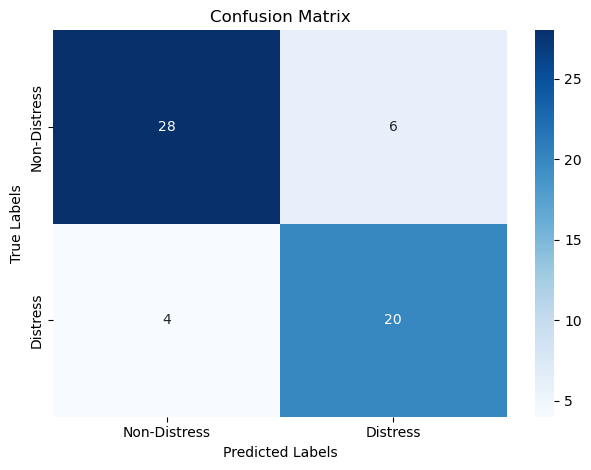

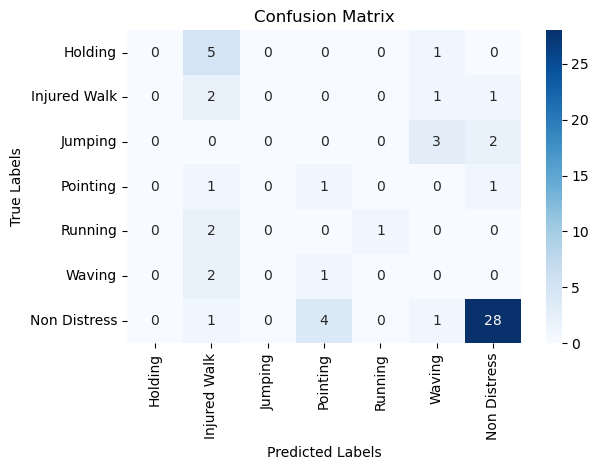

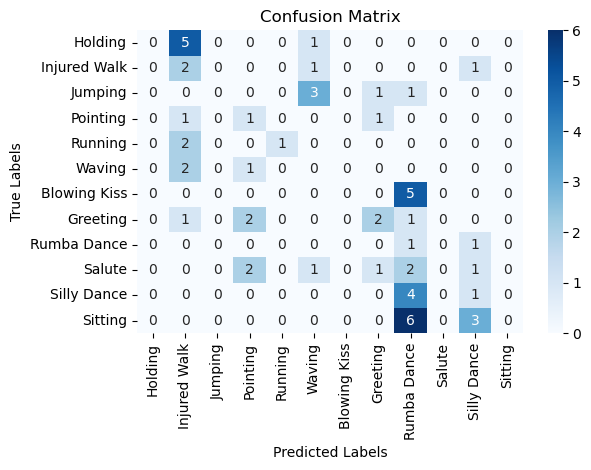

In [19]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_labels):
    print('\n')
    sns.heatmap(
        conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
        xticklabels=class_labels, yticklabels=class_labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()


# Evaluate the model as a binary classification problem
# 'Detect Distress vs Non-distress'
class_labels1 = ["Non-Distress", "Distress"]
plot_confusion_matrix(conf_mat1, class_labels1)

# Evaluate the model as a multiclass classification problem across distress classes
# 'Detect Distress type IF Distress action'
class_labels2 = ["Holding", "Injured Walk", "Jumping", \
                "Pointing", "Running", "Waving", "Non Distress"]
plot_confusion_matrix(conf_mat2, class_labels2)

# Evaluate the model as a multiclass classification problem across all classes
# 'Detect Action'
class_labels3 = ["Holding", "Injured Walk", "Jumping",
                "Pointing", "Running", "Waving", "Blowing Kiss", "Greeting", 
                "Rumba Dance", "Salute", "Silly Dance", "Sitting"]
plot_confusion_matrix(conf_mat3, class_labels3)